# IRCS polarimetry reduction pipeline

* IRCS K-band PDI engineering data was kindly provided by Kudo-san on 2017/04/10
* check obslog e.g. CYG OB2 3 in [SMOKA](http://smoka.nao.ac.jp/search?resolver=NONE&object=CYG%20OB2%203&instruments=IRC&spectrographs=IRC&obs_mod=all&data_typ=OBJECT&dispcol=default&action=Search&diff=1000&asciitable=Table)


* object: BD323739 (as unpolarized standard star)
* object: Cyg OB2 #3 (as polarized standard star)

* IRCA00428737-756: half waveplate 4 position sets (1set: 0-45-22.5-67.5 deg)
* flat image using Cal source at NsIR
 * IRCA00428919-930:  Flat ON,   wp pos 0 deg.
 * IRCA00428931-942:  Flat ON,   wp pos 45 deg.
 * IRCA00428943-954:  Flat ON,   wp pos 22.5 deg.
 * IRCA00428955-966:  Flat ON,   wp pos 67.5 deg.
 * IRCA00428967-978:  Flat OFF,  wp pos 0 deg.
 * IRCA00428979-990:  Flat OFF,  wp pos 45 deg.
 * IRCA00428991-9002: Flat OFF,  wp pos 22.5 deg.
 * IRCA00429003-014:  Flat OFF,  wp pos 67.5 deg.

Vizier/simbad: (unavailable) but see [BD+32 3739, HD 331891](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=HD+331891)

* J 8.800
* H 8.775
* K 8.721 

## Data Reduction Pipeline

* inspecting raw data
* making dark frame
* making cal-flat frame
* masking bad pixels
* making sky-flat frame
* subtracting flat-field
* subtracting sky frame
* interpolating for bad pixel
* measuring position offset
* shifting and combining images (image registration)
* analyzing standard star
* estimating limiting magnitude

## Check header

In [2]:
import numpy as np
try:
    from astropy.io import fits as pf
except:
    import pyfits as pf
from glob import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm

Uyama-san already did the 
* geometric distortion correction
* sky subtraction
* cropping
* image registration. alignment

I'll try to create Q, U, and I images.

In [7]:
input_dir = '/home/jp/data/raw/oe'
ch1_list = glob(os.path.join(input_dir,'skysub_gch1*_r.fits'))
ch2_list = glob(os.path.join(input_dir,'skysub_gch2*_r.fits'))
ch1_list.sort()
ch2_list.sort()
print(len(ch1_list), len(ch2_list))

(20, 20)


## Test image

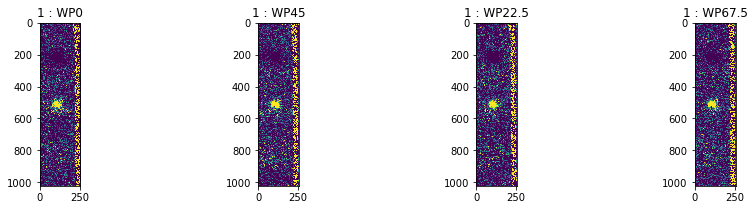

In [36]:
fig,ax = plt.subplots(nrows=1,ncols=4, figsize=(15,3))

for idx, i in enumerate(ch1_list[:4]):
    img=pf.open(i)[0].data
    hdr=pf.open(i)[0].header
    vmin, vmax= np.median(img), 10*np.median(img)
    dither = hdr['I_DTHPOS']
    
    ax1 = ax[idx].imshow(img, vmin=1, vmax=100)
    ax[idx].set_title(dither)
    #fig.colorbar(ax1, ax=ax[0])

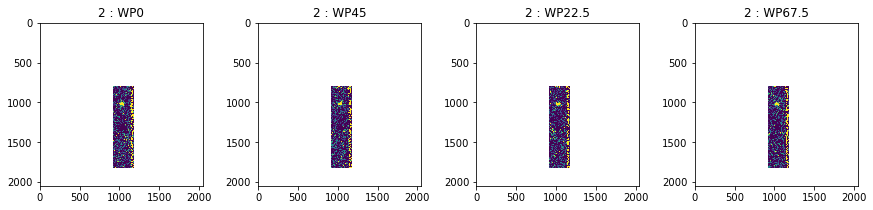

In [75]:
fig,ax = plt.subplots(nrows=1,ncols=4, figsize=(15,3))

for idx, i in enumerate(ch2_list[4:8]):
    img=pf.open(i)[0].data
    hdr=pf.open(i)[0].header
    vmin, vmax= np.median(img), 10*np.median(img)
    dither = hdr['I_DTHPOS']
    
    ax1 = ax[idx].imshow(img, vmin=1, vmax=100)
    ax[idx].set_title(dither)
    #fig.colorbar(ax1, ax=ax[0])

Make I image

In [73]:
image_ch1 = {}
image_ch2 = {}
#otherwise read from file
for i in ch1_list:
    dither = pf.open(i)[0].header['I_DTHPOS']
    image1 = np.copy(pf.open(i)[0].data)
    image_ch1[dither]=image1
    print(image_ch1[dither].shape)

for j in ch2_list:
    dither = pf.open(j)[0].header['I_DTHPOS']
    image2 = np.copy(pf.open(j)[0].data)
    image_ch2[dither]=image2
    print(image_ch2[dither].shape)

(1024, 256)
(1024, 256)
(1024, 256)
(1024, 256)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(1024, 256)
(1024, 256)
(1024, 256)
(1024, 256)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 2048)


In [67]:
image_ch1.keys()

['1 : WP67.5',
 '2 : WP0',
 '4 : WP45',
 '3 : WP22.5',
 '1 : WP45',
 '3 : WP67.5',
 '5 : WP22.5',
 '2 : WP67.5',
 '1 : WP0',
 '1 : WP22.5',
 '5 : WP0',
 '5 : WP67.5',
 '4 : WP22.5',
 '3 : WP45',
 '2 : WP45',
 '5 : WP45',
 '4 : WP0',
 '3 : WP0',
 '4 : WP67.5',
 '2 : WP22.5']

In [71]:
image_ch2[str(5)+' : WP45']

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)

In [59]:
I = {}
I['WP0'] = []
I['WP45'] = []
I['WP22.5'] = []
I['WP67.5'] = []

for k in range(4):#header_o[dither]['I_DTHNUM']):
    I['WP0'].append(image_ch1[str(k+1)+' : WP0'])
    I['WP45'].append(image_ch1[str(k+1)+' : WP45'])
    I['WP22.5'].append(image_ch1[str(k+1)+' : WP22.5'])
    I['WP67.5'].append(image_ch1[str(k+1)+' : WP67.5'])

In [61]:
I['WP45']

[array([[ -5.71952343e+00,  -1.32828522e+01,   1.30508041e+01, ...,
           1.48398514e+01,  -2.67415619e+00,  -4.32629585e+01],
        [  1.66925573e+00,  -8.53753662e+00,   5.50928192e+01, ...,
           5.01095314e+01,   2.54764671e+01,   1.51203125e+03],
        [  1.92736073e+01,   2.83500805e+01,   3.47289124e+01, ...,
           7.69038391e+01,   5.16867142e+01,   7.81096802e+02],
        ..., 
        [  1.68220520e+01,  -2.35459824e+01,  -2.32760010e+01, ...,
           3.35279083e+01,   1.39771271e+01,   2.89461288e+01],
        [  4.40447845e+01,   2.14098282e+01,  -3.41430664e+00, ...,
           5.08976135e+01,   8.08535385e+01,   1.11347618e+02],
        [  5.64826965e-01,   2.12098465e+01,  -3.38551331e+00, ...,
           2.66625061e+01,   6.72583618e+01,   3.29273834e+01]], dtype=float32),
 array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ 

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=4, figsize=(15,3))

In [ ]:
#I_i = ch1+ch2

Make Q and U

In [ ]:
#I = (image_ch1[str(k)+' : WP0'] + image_ch1[str(k)+' : WP45'] + image_ch1[str(k)+' : WP22.5'] + image_ch1[str(k)+' : WP67.5'])/4.0
    #a=[ch1(0)-ch2(0)] - [ch1(45)-ch2(45)]
    #a = (image_ch1[str(k)+' : WP0'] - image_ch2[str(k)+' : WP0']) - (image_ch1[str(k+1)+' : WP45'] - image_ch2[str(k+1)+' : WP45']) -
    #p=[ch1(22.5)-ch2(22.5)] - [ch1(67.5)-ch2(67.5)]
    #p = (image_ch1[str(k+2)+' : WP22.5'] - image_ch2[str(k+2)+' : WP22.5']) - (image_ch1[str(k+3)+' : WP67.5'] - image_ch2[str(k+3)+' : WP67.5']) - 
    #Q = (a-p)*I